In [1]:
import geopandas as gpd
import osmnx as ox
import xgboost as xgb
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier
import time 
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,roc_auc_score,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly
from imblearn.over_sampling import SMOTE,ADASYN 
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix,f1_score,ConfusionMatrixDisplay

C:\Users\Diametrix\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Diametrix\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Diametrix\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Diametrix\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\2181532824.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force

In [2]:
path=r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\batiments_levels"
list_departement=pd.read_excel(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\\Liste-Excel-des-departements-francais.xlsx")

In [3]:
iris_data=pd.read_excel("Y:\REFERENTIEL DATA\RP 2022 FRANCE\GEODATA - IRIS\Geodata_IRIS_essentiels.xlsx")
contour_iris=gpd.read_file(r'Y:\REFERENTIEL DATA\RP 2022 FRANCE\CARTOGRAPHIE\Cartographie_France_IRIS_2019\CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2019\CONTOURS-IRIS.shp').to_crs('EPSG:3857')

In [5]:
iris_data=iris_data.set_index("CODE_IRIS")

In [15]:
building_no_na=[]
all_nearby_buildings={}
iris_building_id=[]
all_building=[]
for i ,row in list_departement.iterrows():
    try:
        contour_iris_dep=contour_iris
        #get all the buildings in the area
        building=pd.read_pickle(path+r"\\"+row["Département"].lower()+"_buildings.pkl").to_crs('EPSG:3857')
        all_building.append(building)
        #get only the buildings with no Nan values
        building_no=building[building['building']!="yes"]
        
        
        building_no_na.append(building_no)
        print(row["Département"].lower())
        print(building_no.shape)
        #get the iris of each building
        iris_buildings=gpd.sjoin(building,contour_iris_dep,predicate="intersects",how="left")
        
        iris_buildings = iris_buildings[~iris_buildings.index.duplicated(keep='first')].reset_index()
        
        #ici pour enregistrer les iris des batiments
        iris_building_id.append(iris_buildings[["index_right",'element_type',"osmid"]].set_index(['element_type',"osmid"]))
     
        iris_buildings=gpd.GeoDataFrame(
        iris_buildings[['element_type',"osmid","CODE_IRIS"]].merge(contour_iris_dep[['CODE_IRIS',"geometry"]],left_on="CODE_IRIS",right_on="CODE_IRIS"),

        ).set_geometry("geometry").set_crs('EPSG:3857')
        
     
        #get the iris that touches each other
        xx=gpd.sjoin(iris_buildings,contour_iris_dep,predicate="touches")
        nearby_buildings=xx[["osmid",'element_type',"CODE_IRIS_left","index_right"]].groupby(["element_type",'osmid'])['index_right'].apply(list)
        #nearby_buildings contains {"building _id": list of nearby iris}
        nearby_buildings=nearby_buildings.to_dict()
        all_nearby_buildings.update(nearby_buildings)
   
    except:
        print('####################')
        print(row['Département'])
        print('####################')
        pass

ain
(349, 10)
####################
Aisne
####################
allier
(16735, 10)
####################
Alpes-de-Haute-Provence
####################
####################
Hautes-Alpes
####################
alpes-maritimes
(11846, 6)
####################
Ardèche
####################
####################
Ardennes
####################
####################
Ariège
####################
aube
(1407, 10)
####################
Aude
####################
####################
Aveyron
####################
bouches-du-rhône
(20820, 6)
calvados
(11236, 10)
####################
Cantal
####################
####################
Charente
####################
####################
Charente-Maritime
####################
####################
Cher
####################
####################
Corrèze
####################
####################
Corse-du-Sud
####################
####################
Haute-Corse
####################
côte-d'or
(6648, 10)
####################
Côtes d'Armor
####################
################

In [16]:
all_building=pd.concat(all_building)
#contient l'iris de chaque batimenet 
iris_building_id=pd.concat(iris_building_id)
building_no_na=pd.concat(building_no_na)
iris_building_id=iris_building_id.reset_index().set_index(["element_type" ,"osmid","index_right"])

In [27]:
'''pickle.dump(all_building,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\all_buildings.pkl","wb"))
pickle.dump(all_nearby_buildings,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\all_nearby_buildings_type.pkl","wb"))
pickle.dump(iris_building_id,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\iris_building_id_type.pkl","wb"))
pickle.dump(building_no_na,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\building_no_na_type.pkl",'wb'))'''

all_building=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\all_buildings.pkl","rb"))
all_nearby_buildings=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\all_nearby_buildings_type.pkl","rb"))
iris_building_id=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\iris_building_id_type.pkl","rb"))
building_no_na=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\building_no_na_type.pkl",'rb'))

In [28]:

keys_nearby_buildings=all_nearby_buildings.keys()

all_indices=[i for i in range(len(all_building))]

In [29]:
iris_building_id=iris_building_id.reset_index().set_index(['element_type','osmid'])

In [30]:
def g(x):
    return list(zip(x['element_type'].values,x['osmid'].values))
iris_building_id['index_left']=[i for i in range(len(iris_building_id))]   
buildings_in_iris_=iris_building_id.reset_index().groupby("index_right").apply(lambda x:list(x['index_left'].values))
buildings_in_iris_index=buildings_in_iris_.index

# binary classification 

In [50]:
def fix(x):
    l=x.split(";")
    if len(l)==0:
        return l
    else:
        for word in l:
            if word !="yes":return word
            
building_no_na['building']=building_no_na['building'].apply(fix)         

In [51]:
building_no_na['building']=np.where(building_no_na['building'].isin(["apartments","terrace","semidetached_house","residential","house","hotel","farm","dormitory","detached"]),1,0)

In [52]:
building_no_na['building'].value_counts()

1    417119
0    140327
Name: building, dtype: int64

In [12]:
def f (x):
    
    #si x is None on retourne -100
    if x is None or x!=x:
        return -100
    else:
        if type(x)==str and x.isnumeric():
            return float(x)
            
        try:
            
            #si x est de forme 1;2;3  on retourne 1#sinon on retoune x
            if type(x) !=  np.int64 and  type(x) !=  np.int32 and type(x) !=int and type(x)!=float:
                
                return float(x.split(';')[0])
            
            else:
                return float(x)
        except:#si x est par example une lettre (cas priculiers ) on retourne 1
            return 1
         

In [27]:
data=np.empty((len(building_no_na),45),dtype="object")

In [28]:
k=10
ids_batiments_voisins=np.empty((len(building_no_na),k),dtype="object")

In [90]:
random_number=np.random.randint(0,len(building_no_na),1)

In [93]:

j=0
import warnings
warnings.filterwarnings("ignore")

#the value to predict
error_building=[]
building_types=[]
start=time.time()
print('number of rows :'+str(len(building_no_na)))

for i ,row in building_no_na.iloc[random_number].iterrows():
    try:
        if j%1000==0 and j!=0:

            print(round(100*j/len(building_no_na),2))
            print(time.time()-start)
            start=time.time()

        building_types.append(row['building'])


        #get the distance between all buildings and our building
        ## get com nearby of the building
        #la deuxieme partie de la condition c'est juste pour vérifier que nearby_buildings[i][0] n'est pas Nan
        if i in  keys_nearby_buildings and all_nearby_buildings[i][0] is not None:

            current_iris_index=iris_building_id.loc[i]['index_right'].values[0]

            #iris nearby
            iris_ids=list(all_nearby_buildings[i])

            iris_ids.append(current_iris_index)
            iris_ids=list(buildings_in_iris_index.intersection(iris_ids))
            flat_list = [item for sublist in buildings_in_iris_.loc[iris_ids].values for item in sublist]
            '''#get all the indices of the buidlings in the nearby iris 
            mask=np.isin(np.array(iris_building_id.index.get_level_values("index_right")),iris_ids)

            #indices_=iris_building_id.iloc[mask].index
            indices=np.where(mask)[0]'''
            indices=flat_list

        else:
            #indices=building.index
            print('####################################')
            indices=all_indices

        #on prend les batiments qui sont dans l'iris MAIS avec un type != yes
        buildings_in_iris=all_building.iloc[indices]

        temp=buildings_in_iris[buildings_in_iris.building !="yes"]

        if len(temp)>=k: 
            buildings_in_iris=temp

        #on calcule la distance entre le batiments et tout les autres batments à coté (avec un type !=yes)
        distance=buildings_in_iris.distance(row['geometry']).sort_values()

        #remove the current building from the distance dataframe (distance will be 0 ofc)
        try:
            distance=distance.drop(i)
        except:
            pass

        #take the k nearest neighboors
        a=buildings_in_iris.loc[distance.index].iloc[:k]
        ids_batiments_voisins[j]=a.index
        #Information about the nearby buildings
        areas=a.area.to_numpy() 
        distances=distance.iloc[:k].to_numpy()
        types=a['building'].to_numpy()
        levels=np.vectorize (f )(a['building:levels'].to_numpy())


        #information about the iris
        iris=contour_iris.iloc[current_iris_index]
        if iris['TYP_IRIS'] ==iris['TYP_IRIS']:
            iris_type=np.array([iris['TYP_IRIS']])
        else:
            iris_type=None
        iris_area=np.array([iris['geometry'].area])


        #information about the building itself
        building_levels=np.array([f(row['building:levels'])])
        area_building=np.array([row['geometry'].area])

        #densité de l'iris
        area=iris["geometry"].area/10**6
        iris=iris_data.loc[iris["CODE_IRIS"]]
        pop=iris['P17_POP']
        densite=[pop/area]


        data[j]=np.concatenate([building_levels,area_building,iris_type,iris_area,densite,areas,types,levels,distances]).ravel()

        break
    except:
        error_building.append(i)
        print("error",i)
    j+=1
'''ss=building_no_na.iloc[random_number].explore(color="red")
ss=buildings_in_iris.loc[distance.index].explore(color="green",m=ss)
a.explore(m=ss)'''

number of rows :557446


'ss=building_no_na.iloc[random_number].explore(color="red")\nss=buildings_in_iris.loc[distance.index].explore(color="green",m=ss)\na.explore(m=ss)'

In [30]:
data

array([[2.0, 357.7942286409007, 'H', ..., 61.977639423710414,
        74.22417710230127, 84.39519785102814],
       [4.0, 1108.3593498003058, 'H', ..., 240.654551763701,
        259.85192906395, 260.7550940097749],
       [2.0, 670.2618483311212, 'H', ..., 396.7315596753791,
        416.26173136958425, 420.43593325399013],
       ...,
       [2.0, 267.7098474707503, 'H', ..., 537.7328247731855,
        665.6030045360951, 700.1481044142464],
       [4.0, 8220.639551283284, 'H', ..., 797.7388599547287,
        801.0570730551042, 832.1967716418235],
       [2.0, 12850.973420852364, 'D', ..., 299.7494206366639,
        305.87985243606505, 315.2637332211616]], dtype=object)

In [61]:
'''pickle.dump(data,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\données modele\\donnée_prediction_types.pkl",'wb'))
pickle.dump(ids_batiments_voisins,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\données modele\\ids_batiments_voisins_prédiction_types.pkl",'wb'))'''
data=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\données modele\\donnée_prediction_types.pkl",'rb'))


In [62]:
k=10
#create a dataframe
columns=["building_level","area_building","iris_type","iris_area","iris_densite"]
for j in ["areas","types","levels","distances"]:
    for i in range(k):
        columns.append(j+str(i))

data_no=pd.DataFrame(data,columns=columns)
data_no.head()

,building_level,area_building,iris_type,iris_area,iris_densite,areas0,areas1,areas2,areas3,areas4,...,distances0,distances1,distances2,distances3,distances4,distances5,distances6,distances7,distances8,distances9
0,2.0,357.794229,H,39045056.799018,80.011647,380.106682,36.261959,293.21807,228.534356,228.859021,...,2.510911,11.220712,15.057363,27.252694,35.57488,39.142103,54.52305,61.977639,74.224177,84.395198
1,4.0,1108.35935,H,39045056.799018,80.011647,6628.165072,811.268855,243.907994,246.848151,17839.89174,...,0.0,31.92643,72.889812,72.930128,83.180749,188.67751,200.987177,240.654552,259.851929,260.755094
2,2.0,670.261848,H,39045056.799018,80.011647,540.262825,175.529771,444.23995,306.017141,325.247513,...,298.212283,330.281905,345.155772,349.12712,371.611341,371.695885,393.501661,396.73156,416.261731,420.435933
3,1.0,191.935762,H,39045056.799018,80.011647,19837.220202,141.064897,3493.004922,157.048772,126.878198,...,0.0,27.149217,94.437103,121.215785,133.083682,151.967388,165.494002,187.45149,196.422478,202.141044
4,1.0,225.423814,H,39045056.799018,80.011647,31.910782,211.389301,282.359547,249.873228,274.639142,...,0.0,24.016538,24.748066,28.983483,37.95648,43.541802,59.046656,78.644127,103.339459,109.150169


In [63]:
building_types=building_no_na['building'].values

In [64]:
#add the type of building
data_no["y_true"]=building_types

print(data_no.shape)
data_no=data_no.dropna()
print(data_no.shape)
building_types=data_no["y_true"].values
data_no=data_no.drop(["y_true"],axis=1)

(557446, 46)
(557428, 46)


In [65]:
#in case a type is like "yes;appartement " it should be transformed into "appartement"

def fix(x):
    l=x.split(";")
    if len(l)==1:
        return x
    else:
      
        for word in l:
            if word !="yes":return word
for c in data_no.columns:
    if "types" in c:
        print(c)
        data_no[c]=data_no[c].apply(lambda x:fix(x))

types0
types1
types2
types3
types4
types5
types6
types7
types8
types9


In [66]:
data_no.isna().sum().sum()

0

In [67]:
#convert columns from object to int
for c in data_no:
    if "area" in c or "levels" in c or "distances" in c or "iris_densite" in c or "level" in c:
        data_no[c]=data_no[c].astype(np.float)
        print(c)

C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\1398622121.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=data_no[c].astype(np.float)


building_level
area_building
iris_area
iris_densite
areas0
areas1
areas2
areas3
areas4
areas5
areas6
areas7
areas8
areas9
levels0
levels1
levels2
levels3
levels4
levels5
levels6
levels7
levels8
levels9
distances0
distances1
distances2
distances3
distances4
distances5
distances6
distances7
distances8
distances9


In [68]:
list_encoders=[]
from sklearn.preprocessing import OrdinalEncoder
for c in data_no.columns:
    if data_no[c].dtype=="O":
        print(c)
        enc = OrdinalEncoder()
        data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
        list_encoders.append(enc)
        

iris_type
types0


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

types1
types2


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

types3
types4


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

types5
types6


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

types7
types8


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

types9


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_11212\219716581.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_no[c]=enc.fit_transform(data_no[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)


## Model : SMOTE 

In [69]:
#X_train, X_test, y_train, y_test =train_test_split(sample.drop("y",axis=1),sample['y'],test_size=0.15)
X_train, X_test, y_train, y_test =train_test_split(data_no,building_types,random_state=123,test_size=0.25)

<Axes: >

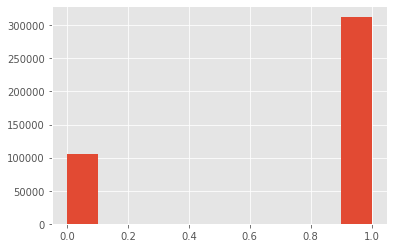

In [74]:
plt.style.use('ggplot')
pd.Series(y_train).hist()

C:\Users\Diametrix\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


<Axes: >

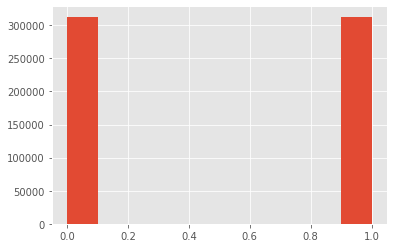

In [75]:

sm = SMOTE(n_jobs=-1)
X_res, y_res = sm.fit_resample(X_train, y_train.reshape((-1,1)))
plt.style.use('ggplot')
pd.Series(y_res).hist()

In [ ]:
ad = ADASYN(n_jobs=-1)
X_res_ad, y_res_ad = ad.fit_resample(X_train, y_train)
plt.style.use('ggplot')
pd.Series(y_res_ad).hist()

<Axes: >

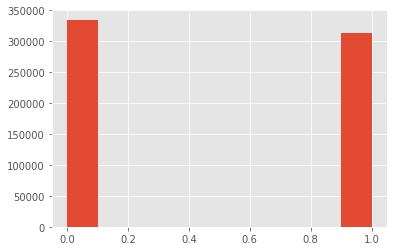

In [77]:
plt.style.use('ggplot')
pd.Series(y_res_ad).hist()

AUC : 0.9316749657115281
accuracy : 0.9518933386912749


<Figure size 1440x1440 with 0 Axes>

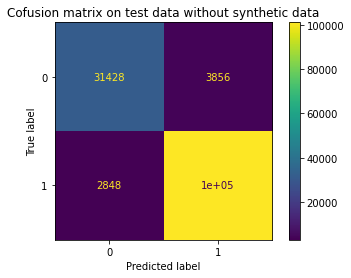

In [159]:

model = xgb.XGBClassifier(n_estimators=100)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print('AUC :',roc_auc_score(y_test,ypred,average=None))
print('accuracy :',accuracy_score(y_test,ypred))
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(y_test,ypred))

p.plot()
plt.title('Cofusion matrix on test data without synthetic data')
plt.show()

In [91]:
confusion_matrix(y_test,ypred).sum()

139357

In [92]:
confusion_matrix(y_test,ypred)

array([[ 31506,   3778],
       [  2959, 101114]], dtype=int64)

AUC : 0.9322470030440784
accuracy : 0.9516565368083412


<Figure size 1440x1440 with 0 Axes>

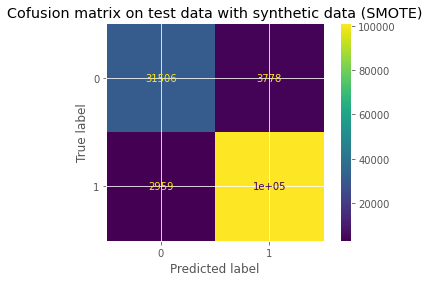

In [89]:

model = xgb.XGBClassifier(n_estimators=100)
model.fit(X_res, y_res)
ypred = model.predict(X_test)
print('AUC :',roc_auc_score(y_test,ypred,average=None))
print('accuracy :',accuracy_score(y_test,ypred))
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(y_test,ypred))

p.plot()
plt.title('Cofusion matrix on test data with synthetic data (SMOTE)')
plt.show()

AUC : 0.9320685643387198
accuracy : 0.9509820102327117


<Figure size 1440x1440 with 0 Axes>

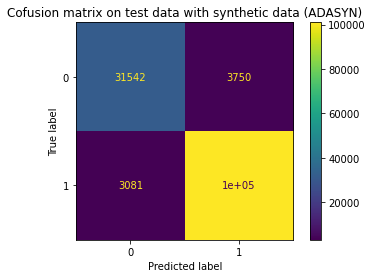

In [56]:

model = xgb.XGBClassifier(n_estimators=100)
model.fit(X_res_ad, y_res_ad)
ypred = model.predict(X_test)
print('AUC :',roc_auc_score(y_test,ypred,average=None))
print('accuracy :',accuracy_score(y_test,ypred))
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(y_test,ypred))

p.plot()
plt.title('Cofusion matrix on test data with synthetic data (ADASYN)')
plt.show()

In [94]:
x=model.feature_names_in_[np.flip(model.feature_importances_.argsort())]
y=np.flip(np.sort(model.feature_importances_))
fig = px.bar(pd.DataFrame({"variables":x,"feature importance":y}), x='variables', y='feature importance',title="Most important variables")

fig.show()

## Train with whole data

AUC : 0.9412568031833585
accuracy : 0.9595786361646705


<Figure size 1440x1440 with 0 Axes>

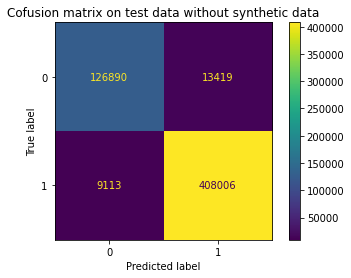

In [75]:
model = xgb.XGBClassifier(n_estimators=100)
model.fit(data_no, building_types)
ypred = model.predict(data_no)
print('AUC :',roc_auc_score(building_types,ypred,average=None))
print('accuracy :',accuracy_score(building_types,ypred))
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(building_types,ypred))

p.plot()
plt.title('Cofusion matrix on test data without synthetic data')
plt.show()

In [76]:
pd.Series(building_types).value_counts()

1    417119
0    140309
dtype: int64

In [77]:
pd.Series(ypred).value_counts()

1    421425
0    136003
dtype: int64

In [80]:
x=model.feature_names_in_[np.flip(model.feature_importances_.argsort())]
y=np.flip(np.sort(model.feature_importances_))
fig = px.bar(pd.DataFrame({"variables":x,"feature importance":y}), x='variables', y='feature importance',title="Les variables les plus pertinents")

fig.show()

In [125]:
pickle.dump(model,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\modeles\\types.pkl","wb"))
#model=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\modeles\\types.pkl","rb"))

# Prediction

In [84]:
building_na=all_building.loc[all_building.index.difference(building_no_na.index)]

In [85]:
iris_building_id_na=iris_building_id.loc[building_na.index]
iris_building_id_na=iris_building_id_na.reset_index().set_index(['element_type',"osmid"])

In [11]:
data_na=np.empty((len(building_na),45),dtype="object")

In [13]:
k=10
ids_batiments_voisins=np.empty((len(building_na),k),dtype="object")

In [17]:
iris_data=iris_data.set_index("CODE_IRIS")

In [14]:
random_number=np.random.randint(0,len(building_no_na),1)

In [19]:
k=10
j=0
import warnings
warnings.filterwarnings("ignore")
print('number of rows :'+str(len(building_na)))
error_building=[]
start=time.time()

for i ,row in building_na.iterrows():
    try:
        if j%1000==0 and j!=0:
            print(round(100*j/len(building_na),2))
            print(time.time()-start)
            start=time.time()

        #get the distance between all buildings and our building
        ## get com nearby of the building
        #la deuxieme partie de la condition c'est juste pour vérifier que nearby_buildings[i][0] n'est pas Nan
        if i in  keys_nearby_buildings and all_nearby_buildings[i][0] is not None:

            current_iris_index=iris_building_id_na.loc[i]['index_right'].values[0]

            #iris nearby
            iris_ids=list(all_nearby_buildings[i])
            iris_ids.append(current_iris_index)
            iris_ids=list(buildings_in_iris_index.intersection(iris_ids))
            flat_list = [item for sublist in buildings_in_iris_.loc[iris_ids].values for item in sublist]
            '''#get all the indices of the buidlings in the nearby iris 
            mask=np.isin(np.array(iris_building_id.index.get_level_values("index_right")),iris_ids)

            #indices_=iris_building_id.iloc[mask].index
            indices=np.where(mask)[0]'''
            indices=flat_list

        else:
            #indices=building.index
            print('####################################')
            indices=buildings_in_iris_.loc[iris_building_id_na.loc[i]['index_right'].values[0]]


        #on prend les batiments qui sont dans l'iris MAIS avec un type != yes
        buildings_in_iris=all_building.iloc[indices]

        temp=buildings_in_iris[buildings_in_iris.building !="yes"]

        if len(temp)>=k: 
            buildings_in_iris=temp

        #on calcule la distance entre le batiments et tout les autres batments à coté (avec un type !=yes)
        distance=buildings_in_iris.distance(row['geometry']).sort_values()

        #remove the current building from the distance dataframe (distance will be 0 ofc)
        try:
            distance=distance.drop(i)
        except:
            pass

        #take the k nearest neighboors
        a=buildings_in_iris.loc[distance.index].iloc[:k]
        ids_batiments_voisins[j]=a.index
        #Information about the nearby buildings
        areas=a.area.to_numpy() 
        distances=distance.iloc[:k].to_numpy()
        types=a['building'].to_numpy()

        levels=np.vectorize (f )(a['building:levels'].to_numpy())


        #information about the iris
        iris=contour_iris.iloc[current_iris_index]
        if iris['TYP_IRIS'] ==iris['TYP_IRIS']:
            iris_type=np.array([iris['TYP_IRIS']])
        else:
            iris_type=None
        iris_area=np.array([iris['geometry'].area])


        #information about the building itself
        building_levels=np.array([f(row['building:levels'])])
        area_building=np.array([row['geometry'].area])

        #densité de l'iris
        area=iris["geometry"].area/10**6
        iris=iris_data.loc[iris["CODE_IRIS"]]
        pop=iris['P17_POP']
        densite=[pop/area]


        data_na[j]=np.concatenate([building_levels,area_building,iris_type,iris_area,densite,areas,types,levels,distances]).ravel()

  
    except:
        error_building.append(i)
        print("error",i)
    j+=1


number of rows :5895805
0.02
157.84166932106018
0.03
10.170872449874878
0.05
10.93582034111023
0.07
10.78326940536499
0.08
10.6685311794281
0.1
10.631651639938354
0.12
12.75600814819336
0.14
10.550846099853516
0.15
12.107736825942993
0.17
12.60639214515686
0.19
12.594742059707642
0.2
13.407251119613647
0.22
13.142953395843506
0.24
13.670571088790894
0.25
12.827795267105103
0.27
13.776246786117554
####################################
####################################
####################################
0.29
15.459804773330688
0.31
15.299200057983398
####################################
0.32
15.83377981185913
0.34
15.138613939285278
0.36
16.169904947280884
0.37
17.85506772994995
0.39
16.58079195022583
####################################
####################################
####################################
####################################
####################################
0.41
13.943793535232544
####################################
####################################
####

4.0
11.094160795211792
4.02
10.689878940582275
4.04
10.682532787322998
4.05
10.748687028884888
4.07
11.84437346458435
4.09
11.464901208877563
4.1
10.949424505233765
4.12
10.888082265853882
4.14
11.001219034194946
4.16
11.007422685623169
4.17
10.886244535446167
4.19
10.6520254611969
4.21
15.749056816101074
4.22
16.452632665634155
4.24
16.32885479927063
4.26
13.335625886917114
4.27
9.511423110961914
4.29
11.054254293441772
4.31
10.896677255630493
4.33
10.811774969100952
4.34
10.865356922149658
4.36
9.765918731689453
4.38
11.508156776428223
4.39
9.45408034324646
4.41
12.304414510726929
4.43
13.515817403793335
4.44
11.925951480865479
4.46
11.394951581954956
4.48
11.438177585601807
4.49
11.110929012298584
4.51
11.253922462463379
4.53
11.818607807159424
4.55
16.03581666946411
4.56
16.066872358322144
4.58
15.613211870193481
4.6
16.00440812110901
4.61
16.119757890701294
4.63
16.245857000350952
4.65
16.019652128219604
4.66
15.687974452972412
4.68
15.037588119506836
4.7
11.172358274459839
4.72
1

9.89
11.647615194320679
9.91
16.26486587524414
9.92
18.865427017211914
9.94
19.03571105003357
9.96
18.750213861465454
9.97
16.045174837112427
9.99
14.623104333877563
10.01
15.17091965675354
10.02
17.059346437454224
10.04
16.976851224899292
10.06
13.6271071434021
10.07
13.486496925354004
10.09
13.444183588027954
10.11
13.868536472320557
10.13
14.00960397720337
10.14
14.121992111206055
10.16
13.877039909362793
10.18
11.861971139907837
10.19
14.644054651260376
10.21
15.375397205352783
10.23
14.623396873474121
10.24
19.991373777389526
10.26
19.882155179977417
10.28
19.69758152961731
10.3
18.543132305145264
10.31
12.862364292144775
10.33
11.682209491729736
10.35
10.682028532028198
10.36
10.705421924591064
10.38
10.710351467132568
10.4
10.737655878067017
10.41
10.974385738372803
10.43
10.883964776992798
10.45
11.7290780544281
10.47
12.012780666351318
10.48
12.340437650680542
10.5
13.380447149276733
10.52
13.665802955627441
10.53
13.559371709823608
10.55
11.985909223556519
10.57
11.5773222446

15.21
11.61234188079834
####################################
####################################
####################################
15.23
11.599478483200073
####################################
####################################
####################################
15.25
11.482543230056763
####################################
####################################
####################################
####################################
####################################
15.27
11.715136289596558
####################################
####################################
####################################
####################################
####################################
####################################
15.28
13.043946981430054
####################################
####################################
####################################
####################################
####################################
15.3
12.61872911453247
####################################
##

20.0
11.460774183273315
20.01
10.401829242706299
20.03
10.187659978866577
20.05
9.898430109024048
20.07
10.06258249282837
20.08
11.193475484848022
20.1
11.197180986404419
20.12
11.283620357513428
20.13
11.222578048706055
20.15
11.198630571365356
20.17
11.872835874557495
20.18
12.594677448272705
20.2
12.812979221343994
20.22
11.189223527908325
20.23
10.721420049667358
20.25
12.76780104637146
20.27
13.363447427749634
20.29
16.75142002105713
20.3
16.649537801742554
20.32
14.647841691970825
20.34
13.955381393432617
20.35
14.810761213302612
20.37
10.331642627716064
20.39
13.401281356811523
20.4
18.155766010284424
20.42
18.101208925247192
20.44
19.891615629196167
20.46
20.734476566314697
20.47
20.908040285110474
20.49
20.743213653564453
20.51
16.564952611923218
20.52
15.548234462738037
20.54
15.42257833480835
20.56
15.499966621398926
20.57
15.550579309463501
20.59
15.373254299163818
20.61
15.404438257217407
20.62
17.944244146347046
20.64
18.58893084526062
20.66
17.571254014968872
20.68
18.54

25.63
13.19281816482544
25.65
11.763315200805664
25.66
11.504599809646606
25.68
11.899014711380005
25.7
12.816134214401245
25.71
12.980257034301758
25.73
12.974238395690918
25.75
11.374539613723755
25.76
10.349051475524902
25.78
15.558420896530151
25.8
15.363380908966064
25.81
12.00094223022461
25.83
12.743337154388428
25.85
12.048200607299805
25.87
12.133941411972046
25.88
12.250770807266235
25.9
12.040666818618774
25.92
12.1247878074646
25.93
12.823518514633179
25.95
13.552618503570557
25.97
13.69737458229065
25.98
13.04875898361206
26.0
12.980850219726562
26.02
13.315977573394775
26.04
11.831026315689087
26.05
11.494716882705688
26.07
13.022916555404663
26.09
11.32861614227295
26.1
10.046681642532349
26.12
9.811174154281616
26.14
9.822529792785645
26.15
10.288771152496338
26.17
11.353666543960571
26.19
11.454480171203613
26.21
11.40001130104065
26.22
11.989330053329468
26.24
17.812669038772583
26.26
12.077311754226685
26.27
10.097641229629517
26.29
12.871703386306763
26.31
13.662420

31.28
14.19642448425293
31.29
14.588232278823853
31.31
12.570425033569336
31.33
15.884665966033936
31.34
18.488927841186523
31.36
18.73499345779419
31.38
13.184786319732666
31.4
11.552154064178467
31.41
11.138364553451538
31.43
11.235215187072754
31.45
11.272320985794067
31.46
11.214829683303833
31.48
13.885972499847412
31.5
16.879873752593994
31.51
16.3964786529541
31.53
16.40340805053711
31.55
16.428933143615723
31.56
16.35025644302368
31.58
16.554243087768555
31.6
12.408093214035034
31.62
10.962145566940308
31.63
10.536890983581543
31.65
10.658214569091797
31.67
10.90338683128357
31.68
10.853610277175903
31.7
10.88526463508606
31.72
10.972848176956177
31.73
10.915404558181763
31.75
10.898005723953247
31.77
11.50426721572876
31.79
12.462548017501831
31.8
13.047911167144775
31.82
14.259047746658325
31.84
11.273180484771729
31.85
12.823641300201416
31.87
12.898138284683228
31.89
12.814866781234741
31.9
12.79560136795044
31.92
12.854886293411255
31.94
12.792002439498901
31.95
12.8436229

36.74
11.919737339019775
36.75
10.273755073547363
36.77
10.340991258621216
36.79
12.628363609313965
36.81
12.430017948150635
36.82
12.582278490066528
36.84
12.732964992523193
36.86
12.497103691101074
36.87
12.599333047866821
36.89
12.388845205307007
36.91
16.430164337158203
36.92
17.3382568359375
36.94
17.495598077774048
36.96
17.462723970413208
36.98
17.472607374191284
36.99
17.496809720993042
####################################
37.01
11.651157140731812
37.03
10.422551155090332
37.04
10.397170782089233
37.06
10.36177921295166
37.08
10.405025005340576
37.09
10.793579339981079
37.11
17.007747888565063
37.13
16.902353525161743
37.15
14.690385580062866
37.16
15.632039546966553
37.18
16.75971245765686
37.2
17.031222343444824
37.21
12.290924310684204
37.23
10.171847820281982
37.25
10.05348014831543
37.26
10.203468799591064
37.28
14.773804664611816
37.3
17.421441793441772
37.31
17.36880397796631
37.33
17.23808002471924
37.35
17.43976902961731
37.37
17.35788345336914
37.38
17.195034980773926

42.3
17.5752170085907
42.32
14.206766128540039
42.34
11.58380913734436
42.35
15.70299243927002
42.37
17.79640769958496
42.39
17.892765283584595
42.4
16.354656219482422
42.42
12.278369665145874
42.44
11.941939115524292
42.45
11.6205735206604
42.47
11.629433393478394
42.49
11.005152225494385
42.5
10.867857456207275
42.52
10.899745225906372
42.54
11.063424587249756
42.56
11.573800086975098
42.57
12.33917498588562
42.59
12.946848392486572
42.61
12.348576307296753
42.62
12.723652839660645
42.64
12.866615533828735
42.66
12.508623123168945
42.67
13.102872848510742
42.69
14.286816835403442
42.71
13.019256114959717
42.73
13.087913990020752
42.74
13.915832042694092
42.76
14.076673984527588
42.78
13.9443998336792
42.79
14.673667669296265
42.81
14.734131336212158
42.83
12.76868748664856
42.84
13.780506134033203
42.86
15.567840576171875
42.88
15.503274917602539
42.89
15.303122758865356
42.91
20.322781562805176
42.93
16.518478393554688
42.95
13.013707160949707
42.96
12.41597056388855
42.98
12.339613

47.93
14.005574703216553
47.95
14.549986362457275
47.97
14.516057014465332
47.98
14.820012092590332
48.0
13.996902227401733
48.02
15.104270458221436
48.03
15.1690833568573
48.05
14.919627904891968
48.07
15.123085737228394
48.09
14.82877779006958
48.1
18.951929807662964
48.12
20.13623571395874
48.14
14.07330584526062
48.15
13.904824495315552
48.17
13.105473279953003
48.19
12.682474374771118
48.2
13.885943412780762
48.22
13.407390832901001
48.24
12.405436277389526
48.25
12.18195366859436
48.27
12.656322479248047
48.29
13.756407260894775
48.31
15.02875304222107
48.32
15.22221040725708
48.34
12.712358713150024
48.36
12.796733856201172
48.37
12.714290618896484
48.39
12.702173709869385
48.41
13.638033151626587
48.42
13.528372526168823
48.44
13.32603907585144
48.46
14.219483137130737
48.48
15.062836647033691
48.49
10.09028697013855
48.51
12.870945453643799
48.53
13.084169626235962
48.54
13.067878723144531
48.56
12.927754402160645
48.58
12.898037433624268
48.59
12.959794998168945
48.61
13.0657

53.44
10.979060649871826
53.46
11.428579330444336
53.48
11.338994264602661
53.5
11.046441078186035
53.51
11.06138825416565
53.53
10.45133376121521
53.55
15.2248694896698
53.56
14.548581838607788
53.58
16.49659276008606
53.6
16.48194193840027
53.61
16.397069931030273
53.63
16.48163652420044
53.65
16.49368190765381
53.67
13.006450176239014
53.68
14.51732850074768
53.7
16.24987030029297
53.72
15.958974599838257
53.73
15.908128261566162
53.75
13.972911357879639
53.77
13.657461643218994
53.78
13.985271215438843
53.8
14.076143503189087
53.82
14.014986276626587
53.83
14.099812507629395
53.85
14.01919150352478
53.87
14.029810428619385
53.89
13.852266550064087
53.9
13.692457914352417
53.92
14.111148595809937
53.94
13.805763244628906
53.95
13.70248007774353
53.97
13.908533573150635
53.99
10.619635820388794
54.0
10.16098141670227
54.02
13.342944383621216
54.04
15.315609216690063
54.06
14.497231483459473
54.07
12.333920955657959
54.09
10.135751247406006
54.11
10.070557594299316
54.12
13.0189998149

59.09
27.043991327285767
59.11
23.898114681243896
59.13
24.525644302368164
59.14
19.21234655380249
59.16
13.794496774673462
59.18
14.233104944229126
59.19
13.974395275115967
59.21
13.4014253616333
59.23
11.4524405002594
59.25
11.840034008026123
59.26
11.70720100402832
59.28
12.908019781112671
59.3
12.912429332733154
59.31
12.847231388092041
59.33
12.744640588760376
59.35
12.746604204177856
59.36
11.286489486694336
59.38
11.523592710494995
59.4
12.14827561378479
59.42
12.930004358291626
59.43
13.683908939361572
59.45
16.47563886642456
59.47
11.394356489181519
59.48
11.375524044036865
59.5
16.873268604278564
59.52
13.875755786895752
59.53
14.048138618469238
59.55
13.375061988830566
59.57
12.187730550765991
59.58
12.23247766494751
59.6
13.48792314529419
59.62
13.48125410079956
59.64
13.49803376197815
59.65
13.329824209213257
59.67
13.081309080123901
59.69
12.983803272247314
59.7
12.41971206665039
59.72
11.993391990661621
59.74
10.545486450195312
59.75
10.331197738647461
59.77
10.335820674

64.74
14.346076965332031
64.76
13.88706660270691
64.77
14.813965797424316
64.79
15.639151334762573
64.81
12.03458571434021
64.83
13.887141942977905
64.84
12.350407838821411
64.86
11.964879751205444
64.88
12.02961015701294
64.89
12.424214839935303
64.91
11.78473949432373
64.93
11.885433673858643
64.94
15.671469449996948
64.96
13.64317011833191
64.98
11.803856611251831
65.0
11.654704332351685
65.01
11.960663318634033
65.03
10.26527738571167
65.05
10.57143259048462
65.06
12.466119527816772
65.08
11.825848817825317
65.1
11.196106910705566
65.11
11.118136882781982
65.13
11.449310064315796
65.15
11.401018142700195
65.16
10.976004123687744
65.18
9.540751218795776
65.2
11.62077260017395
65.22
11.547873497009277
65.23
11.502161502838135
65.25
11.621662855148315
65.27
11.308922052383423
65.28
11.252128601074219
65.3
11.206950426101685
65.32
10.248762845993042
65.33
10.629241228103638
65.35
10.973475217819214
65.37
9.761730432510376
65.39
9.812820672988892
65.4
9.784400701522827
65.42
9.730129480

70.39
13.110095739364624
70.41
13.764626026153564
70.42
13.647167205810547
70.44
12.855269193649292
70.46
12.63045597076416
70.47
12.631068468093872
70.49
12.743963479995728
70.51
12.695537805557251
70.52
12.746774435043335
70.54
12.680373907089233
70.56
12.401269912719727
70.58
11.133195877075195
70.59
11.39798641204834
70.61
11.493558883666992
70.63
10.881150007247925
70.64
11.060606241226196
70.66
11.097118377685547
70.68
11.132508754730225
70.69
10.745450735092163
70.71
10.613737106323242
70.73
10.89652156829834
70.75
9.79145073890686
70.76
10.93051815032959
70.78
10.606901407241821
70.8
11.31859827041626
70.81
13.02211880683899
70.83
12.029710054397583
70.85
11.924849271774292
70.86
10.847596883773804
70.88
11.373456001281738
70.9
11.56758451461792
70.91
11.962589502334595
70.93
13.271856307983398
70.95
12.686151027679443
70.97
12.816207885742188
70.98
12.272545337677002
71.0
12.351649284362793
71.02
13.79152798652649
71.03
13.574973583221436
71.05
13.442283630371094
71.07
12.6126

76.02
15.56996750831604
76.04
15.617461204528809
76.05
15.069809675216675
76.07
13.534401655197144
76.09
15.934478998184204
76.1
15.164748907089233
76.12
15.471628189086914
76.14
15.40021824836731
76.16
16.555721521377563
76.17
14.038769721984863
76.19
14.904049396514893
76.21
12.59883737564087
76.22
12.129065036773682
76.24
12.06971001625061
76.26
12.657971858978271
76.27
11.41178560256958
76.29
12.275196075439453
76.31
13.373231887817383
76.33
12.620603084564209
76.34
12.373575210571289
76.36
12.195036888122559
76.38
12.078750133514404
76.39
11.874022722244263
76.41
12.00222897529602
76.43
12.02854037284851
76.44
12.395254373550415
76.46
13.773963212966919
76.48
14.125202894210815
76.5
13.954084157943726
76.51
14.016368865966797
76.53
14.115864038467407
76.55
14.247281789779663
76.56
13.59743857383728
76.58
12.03068232536316
76.6
13.715836763381958
76.61
13.314815998077393
76.63
13.252281188964844
76.65
13.526886224746704
76.66
13.552347421646118
76.68
13.446321725845337
76.7
13.2888

####################################
####################################
####################################
####################################
####################################
####################################
####################################
81.67
13.328066349029541
81.69
13.617740392684937
81.7
13.816559553146362
81.72
13.27590799331665
81.74
12.850736141204834
81.75
12.965166091918945
81.77
12.304324865341187
81.79
12.394615173339844
81.8
12.585977554321289
81.82
14.179951667785645
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
#############

86.25
12.795856475830078
86.26
11.943705081939697
86.28
12.033298969268799
86.3
12.277948141098022
86.32
12.272183895111084
86.33
13.312843084335327
86.35
13.701582431793213
86.37
13.70707082748413
86.38
13.901167392730713
86.4
14.871228456497192
86.42
11.483795404434204
86.43
11.37851858139038
86.45
11.23584508895874
86.47
10.35789155960083
86.49
11.7160165309906
86.5
10.096972227096558
86.52
10.834969758987427
86.54
11.531405210494995
86.55
11.429970979690552
86.57
11.338107347488403
86.59
10.366193532943726
86.6
11.474823713302612
86.62
10.339842796325684
86.64
9.67909836769104
86.65
10.662765979766846
86.67
9.581741571426392
86.69
10.88153076171875
86.71
10.935497283935547
86.72
10.32195782661438
86.74
12.731863498687744
86.76
11.092504739761353
86.77
12.154686450958252
86.79
13.263338327407837
86.81
12.1454918384552
86.82
12.307033061981201
86.84
11.934675455093384
86.86
12.228084802627563
86.88
13.109214305877686
86.89
11.747565031051636
86.91
12.161786317825317
86.93
12.40807676

91.3
12.750359058380127
91.32
11.93292236328125
91.34
11.660766124725342
91.35
11.74903154373169
91.37
11.574799299240112
91.39
13.27559757232666
91.4
12.963655233383179
91.42
13.740193843841553
91.44
13.437884330749512
91.45
13.283235311508179
91.47
13.133813619613647
91.49
12.794414281845093
91.51
14.335606098175049
91.52
14.157582759857178
91.54
14.210937738418579
91.56
14.187345504760742
91.57
14.323187112808228
91.59
13.107044219970703
91.61
17.05743408203125
91.62
16.126487970352173
91.64
16.978662252426147
91.66
16.577087879180908
91.68
16.23533010482788
91.69
16.11769151687622
91.71
16.21585488319397
91.73
16.551663160324097
91.74
12.185616731643677
91.76
9.72930908203125
91.78
9.809709310531616
91.79
11.898525714874268
91.81
15.198620557785034
91.83
12.570919036865234
91.84
17.411520957946777
91.86
13.461403369903564
91.88
14.340157508850098
91.9
13.247870445251465
91.91
12.818641424179077
91.93
13.032072305679321
91.95
13.415753602981567
91.96
12.526070594787598
91.98
12.9909

####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
#

####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
94.2
12.235108375549316
94.22
13.454973220825195
94.24
12.398343563079834
94.25
12.82956314086914
94.27
12.443288087844849
94.29
13.543412685394287
94.3
12.6805260181427
94.32
14.815586805343628
94.34
14.917155265808105
94.36
13.690815925598145
94.37
13.69817042350769
####################################
############################

####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
9

####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
####################################
#

97.9
14.621464967727661
97.92
17.202517986297607
97.93
16.021690845489502
97.95
14.36821722984314
97.97
12.541062831878662
97.98
14.018546104431152
98.0
12.677829265594482
98.02
12.697255849838257
98.04
13.4676673412323
98.05
12.611377477645874
98.07
16.114935874938965
98.09
12.301624059677124
98.1
13.573299407958984
98.12
12.902320384979248
98.14
13.855664730072021
98.15
13.456260442733765
98.17
14.853191375732422
98.19
10.865589141845703
98.21
10.908732414245605
98.22
11.452539205551147
####################################
98.24
14.117727518081665
98.26
13.193506479263306
98.27
12.64336895942688
98.29
12.471242666244507
98.31
12.837031602859497
####################################
98.32
13.482199430465698
98.34
12.968623638153076
####################################
98.36
13.947458267211914
98.38
13.68833613395691
98.39
14.679593801498413
98.41
13.260802507400513
98.43
15.274455785751343
98.44
14.523435592651367
98.46
13.558481693267822
98.48
13.045064926147461
98.49
14.8486762046813

In [22]:
print('No error :',len(error_building))

No error : 0


In [33]:
'''pickle.dump(data_na,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\données modele\\donnée_à_prédire_types.pkl",'wb'))
pickle.dump(ids_batiments_voisins,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\données modele\\ids_batiments_voisins_à_prédire_types.pkl",'wb'))'''
data_na=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\données modele\\donnée_à_prédire_types.pkl",'rb'))


In [34]:
#create a dataframe
columns=["building_level","area_building","iris_type","iris_area","iris_densite"]
for j in ["areas","types","levels","distances"]:
    for i in range(k):
        columns.append(j+str(i))

data_no_pred=pd.DataFrame(data_na,columns=columns)
data_no_pred.head()

,building_level,area_building,iris_type,iris_area,iris_densite,areas0,areas1,areas2,areas3,areas4,...,distances0,distances1,distances2,distances3,distances4,distances5,distances6,distances7,distances8,distances9
0,4.0,2564.214449,H,898706.655227,3277.425015,3946.235054,3813.751802,9094.127663,1621.969413,1848.585904,...,61.223914,64.362423,89.033192,184.812799,208.289971,245.774198,258.280042,259.946051,264.652093,266.977565
1,9.0,9391.609943,H,284455.046435,6985.026595,563.11566,43130.459245,411.60314,276.175455,1410.642713,...,30.370815,56.810023,63.701802,74.429209,82.180849,86.598895,112.168665,118.924597,127.673579,141.740436
2,4.0,18838.431679,H,414825.303509,4693.361239,2496.020102,86.271642,2172.196608,510.679985,1201.692658,...,0.0,13.988666,35.074715,40.91676,41.328715,58.513195,67.802945,85.812805,87.450053,88.066091
3,4.0,6744.612231,H,290274.100008,8611.05053,140.261811,143.101213,473.154145,617.289787,277.588288,...,8.793132,8.938445,10.424506,12.48834,13.272065,16.451206,16.621077,17.540342,21.222006,21.882599
4,5.0,3959.465987,H,898706.655227,3277.425015,1140.450971,1771.843157,7958.938935,35407.304965,6205.636722,...,26.026497,40.583931,78.917604,121.815314,157.410382,166.296313,228.965169,272.455409,292.559215,326.97613


In [35]:

#convert columns from object to int
for c in data_no_pred:
    if "area" in c or "levels" in c or "distances" in c or "iris_densite" in c or "level" in c:
        data_no_pred[c]=data_no_pred[c].astype(np.float)
        print(c)

C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\401246385.py:4: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



building_level
area_building
iris_area
iris_densite
areas0
areas1
areas2
areas3
areas4
areas5
areas6
areas7
areas8
areas9
levels0
levels1
levels2
levels3
levels4
levels5
levels6
levels7
levels8
levels9
distances0
distances1
distances2
distances3
distances4
distances5
distances6
distances7
distances8
distances9


In [36]:
for c in data_no_pred.columns:
    if "types" in c:
        print(c)
        data_no_pred[c]=data_no_pred[c].apply(lambda x:fix(x))

types0
types1
types2
types3
types4
types5
types6
types7
types8
types9


In [37]:
data_no_pred.isna().sum().sum()

0

In [38]:
i=0
print(len(list_encoders))
for c in data_no_pred.columns:
    if data_no_pred[c].dtype=="O":
        print(c)
        
        enc=list_encoders[i]
        enc.set_params(encoded_missing_value=-1,handle_unknown="use_encoded_value")

        data_no_pred[c]=enc.transform(data_no_pred[c].to_numpy().reshape(-1,1) ).squeeze().astype(np.int)
        i+=1
        

11
iris_type


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types0


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types1


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types2


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types3


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types4


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types5


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types6


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types7


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types8


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



types9


C:\Users\Diametrix\AppData\Local\Temp\ipykernel_6300\1026602269.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [173]:
#model=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\modeles\types.pkl","rb"))

In [81]:
prediction=model.predict(data_no_pred)
pd.Series(prediction).value_counts()

1    2952866
0    2942939
dtype: int64

In [35]:

data_filled=pd.read_pickle(path+r"\\processed data\\building_level_filled.pkl")

In [38]:
mask=data_filled['building'].isin(['apartments',"house","residential"])

data_filled.loc[mask[mask].index,"habite"]=1
data_filled.loc[(mask[~mask]).index,"habite"]=0
#à executer si tu as fait une classification binaire au lieu multiclasse
b=data_filled['building']=="yes"
data_filled.loc[b[b].index,'habite']=prediction
pickle.dump(data_filled,open(path+r"\\processed data\\building_level_filled.pkl",'wb'))

In [39]:
data_filled['habite'].value_counts()

1.0    67133
0.0    26409
Name: habite, dtype: int64

In [108]:
path=r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\batiments_levels"
j=0
for i ,row in list_departement.iterrows():
   
        contour_iris_dep=contour_iris
        
        #get the buidlings in teh departement
        try:
            building=pd.read_pickle(path+r"\\"+row["Département"].lower()+"_buildings.pkl").to_crs('EPSG:3857')
        except:
            continue
        
        
        building['building']=np.where(building['building'].isin(["apartments","terrace","semidetached_house","residential","house","hotel","farm","dormitory","detached"]),1,0)
        mask=building.index.isin(building_na.index)
        building.loc[mask,'building']=ypred[:mask.sum() ]
        
        pickle.dump(building,open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\batiments_levels_types\\"+row["Département"].lower()+"_buildings.pkl",'wb'))

   



In [122]:
building=pd.read_pickle(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\batiments_levels_types\\finistère_buildings.pkl").to_crs('EPSG:3857')